# Initialize Enviroment

In [1]:
# LOAD LIBRARIES
import time
startNB = time.time()
import tensorflow as tf, os
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score, accuracy_score
import albumentations as albu, cv2, gc
print('TensorFlow version =',tf.__version__)

TensorFlow version = 2.2.0


In [2]:
# CONFIGURE GPUs
#os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.list_physical_devices('GPU'); print(gpus)
if len(gpus)==1: strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
else: strategy = tf.distribute.MirroredStrategy()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [3]:
# ENABLE MIXED PRECISION for speed
#tf.config.optimizer.set_jit(True)
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
print('Mixed precision enabled')

Mixed precision enabled


In [4]:
# VERSION MAJOR and MINOR for logging
mm = 1; rr = 0

# BEGIN LOG FILE
f = open(f'log-{mm}-{rr}.txt','a')
print('Logging to "log-%i-%i.txt"'%(mm,rr))
f.write('#############################\n')
f.write(f'Trial mm={mm}, rr={rr}\n')
f.write('efNetB4, batch_size=512, seed=42, 64x64, fold=0, LR 1e-3 with 0.75 decay\n')
f.write('#############################\n')
f.close()

BATCH_SIZE = 512
DIM = 64

Logging to "log-1-0.txt"


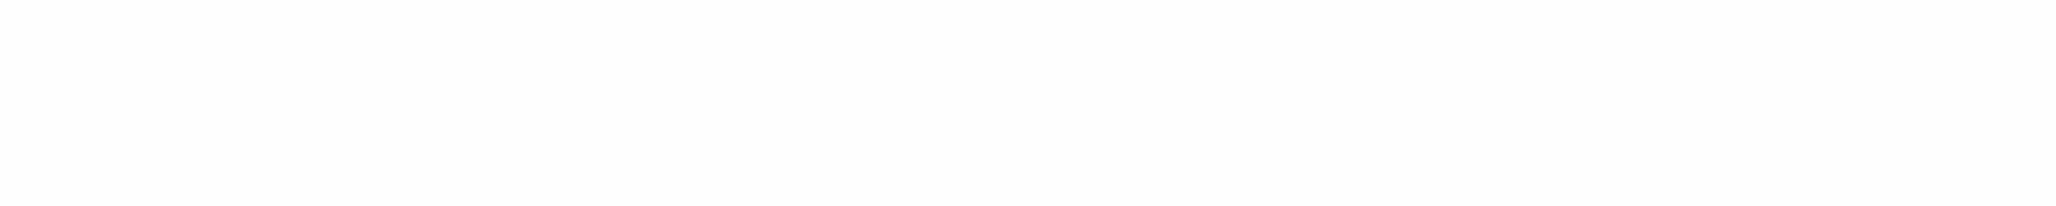

# STEP 1 : Preprocess
Load image data and resize. For optimal GPU speed, we do this one time before the data loader instead of every time each epoch in the data loader. In this tutorial, we only load 25% of data. 

In [5]:
%%time
train = []
#for x in [0,1,2,3]:
for x in [0]:
    f = 'train_image_data_%i.parquet'%x
    print (f,end='')
    img = pd.read_parquet('../data/raw/'+f) # Pandas dataframe
    img = img.iloc[:,1:].values.reshape((-1,137,236,1)) # Numpy Array
    img2 = np.zeros((img.shape[0],DIM,DIM,1),dtype='float32')
    for j in range(img.shape[0]):
        img2[j,:,:,0] = cv2.resize(img[j,],(DIM,DIM),interpolation = cv2.INTER_AREA)
        if j%1000==0: print(j,', ',end='')
    print()
    img2 = (255 - img2)/255.
    train.append(img2)

train_image_data_0.parquet0 , 1000 , 2000 , 3000 , 4000 , 5000 , 6000 , 7000 , 8000 , 9000 , 10000 , 11000 , 12000 , 13000 , 14000 , 15000 , 16000 , 17000 , 18000 , 19000 , 20000 , 21000 , 22000 , 23000 , 24000 , 25000 , 26000 , 27000 , 28000 , 29000 , 30000 , 31000 , 32000 , 33000 , 34000 , 35000 , 36000 , 37000 , 38000 , 39000 , 40000 , 41000 , 42000 , 43000 , 44000 , 45000 , 46000 , 47000 , 48000 , 49000 , 50000 , 
CPU times: user 37 s, sys: 6.04 s, total: 43 s
Wall time: 27.6 s


In [6]:
X_train = np.concatenate(train)
print('Train Shape',X_train.shape)

Train Shape (50210, 64, 64, 1)


In [7]:
del img, img2, train
_ = gc.collect()

## Preprocess - EDA

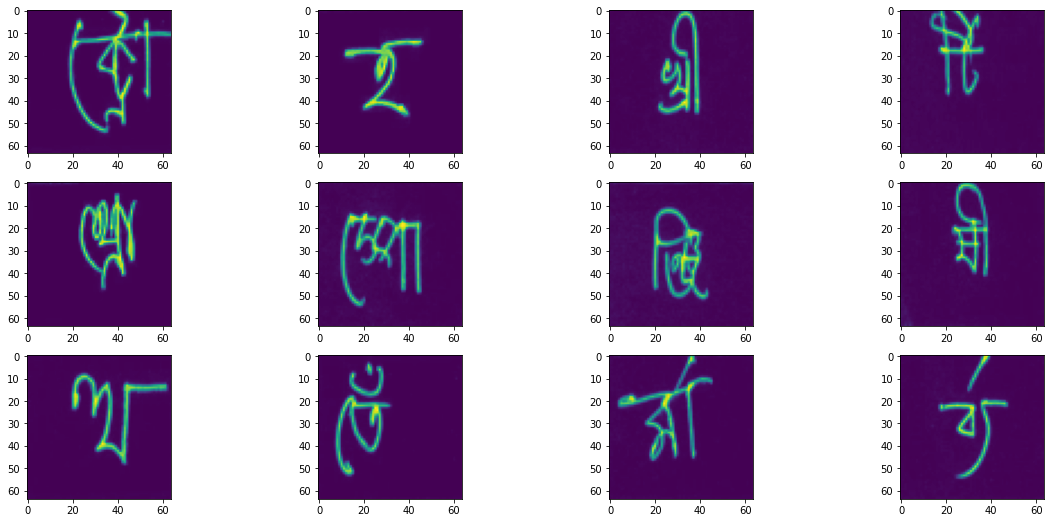

In [8]:
row=3; col=4;
plt.figure(figsize=(20,(row/col)*12))
for x in range(row*col):
    plt.subplot(row,col,x+1)
    plt.imshow(X_train[x,:,:,0])
plt.show()

In [9]:
train = pd.read_csv('../data/raw/train.csv')
y_train = train.iloc[:,1:4].values[:len(X_train)]
print('Labels\nGrapheme Root, Vowel Diacritic, Consonant Diacritic')
y_train

Labels
Grapheme Root, Vowel Diacritic, Consonant Diacritic


array([[ 15,   9,   5],
       [159,   0,   0],
       [ 22,   3,   5],
       ...,
       [ 65,   9,   0],
       [ 24,   0,   0],
       [ 57,   1,   0]])

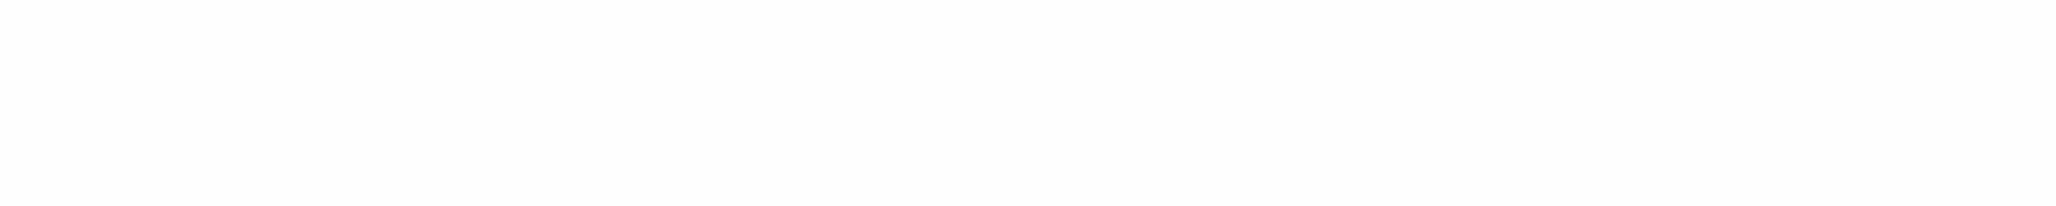

# STEP 2: Data Augmentation
# IMPORTANT: Optimize data loader for GPU Speed!
Build data loader. We want the time to process one batch on CPU less than the time to train one batch on GPU. Also we want to maximize batch size to fully utilize GPU compute.

In [10]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, X, y, list_IDs, batch_size=BATCH_SIZE, shuffle=False, augment=False, 
            labels=True, cutmix=False, yellow=False): 

        self.X = X
        self.y = y
        self.augment = augment
        self.list_IDs = list_IDs
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.labels = labels
        self.cutmix = cutmix
        self.yellow = yellow
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        ct = len(self.list_IDs) // self.batch_size
        ct += int((len(self.list_IDs) % self.batch_size)!=0)
        return ct

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        if self.augment: X = self.__augment_batch(X)
        if self.labels: return X, [y[:,0:168],y[:,168:179],y[:,179:186]]
        else: return X

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange( len(self.list_IDs) )
        if self.shuffle: np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples'        
        X = self.X[ self.list_IDs[indexes], ]
        if self.yellow: X = np.ones((len(indexes),DIM,DIM,1))
        y = np.zeros((len(indexes),186))
        for j in range(len(indexes)):
            y[j, int(self.y[ self.list_IDs[indexes[j]],0]) ] = 1
            y[j, 168 + int(self.y[ self.list_IDs[indexes[j]],1]) ] = 1
            y[j, 179 + int(self.y[ self.list_IDs[indexes[j]],2]) ] = 1
            
        if self.cutmix:
            for j in range(len(indexes)):
                
                # CHOOSE RANDOM CENTER
                yy = np.random.randint(0,DIM)
                xx = np.random.randint(0,DIM)
                z = np.random.choice(self.list_IDs)
                               
                # CHOOSE RANDOM WIDTH AND HEIGHT
                h = np.random.randint(DIM//2-DIM//16,DIM//2+DIM//16)
                w = np.random.randint(DIM//2-DIM//16,DIM//2+DIM//16)
                        
                # CUT AND MIX IMAGES
                ya = max(0,yy-h//2); yb = min(DIM,yy+h//2)
                xa = max(0,xx-w//2); xb = min(DIM,xx+w//2)
                X[j,ya:yb,xa:xb,0] = self.X[z,ya:yb,xa:xb,0]
                
                # CUT AND MIX LABELS
                r = (yb-ya)*(xb-xa)/DIM/DIM
                y2 = np.zeros((1,186))
                y2[0, int(self.y[ z,0]) ] = 1
                y2[0, 168 + int(self.y[ z,1]) ] = 1
                y2[0, 179 + int(self.y[ z,2]) ] = 1                
                y[j,] = (1-r)*y[j,] + r*y2[0,]
                    
        return X, y
 
    def __random_transform(self, img):
        composition = albu.Compose([
            albu.OneOf([
                albu.ShiftScaleRotate(rotate_limit=8,scale_limit=0.16,shift_limit=0,border_mode=0,value=0,p=0.5),
                albu.CoarseDropout(max_holes=16,max_height=DIM//10,max_width=DIM//10,fill_value=0,p=0.5)
            ], p=0.5),
            albu.ShiftScaleRotate(rotate_limit=0, scale_limit=0., shift_limit=0.12, border_mode=0, value=0, p=0.5)
        ])
        return composition(image=img)['image']
    
    def __augment_batch(self, img_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i, ] = self.__random_transform(img_batch[i, ])
        return img_batch

## Data Augmentation - EDA
Cutmix augmentation mixes two images together. In the examples below, the first of the two images has been displayed as all yellow to help us visualize the augmentation better. (During training, the first image will not be converted to yellow). We also observe rotation, scaling, shift and coarse dropout augmentation below.

Cutmix Augmentation with first image displayed as all yellow


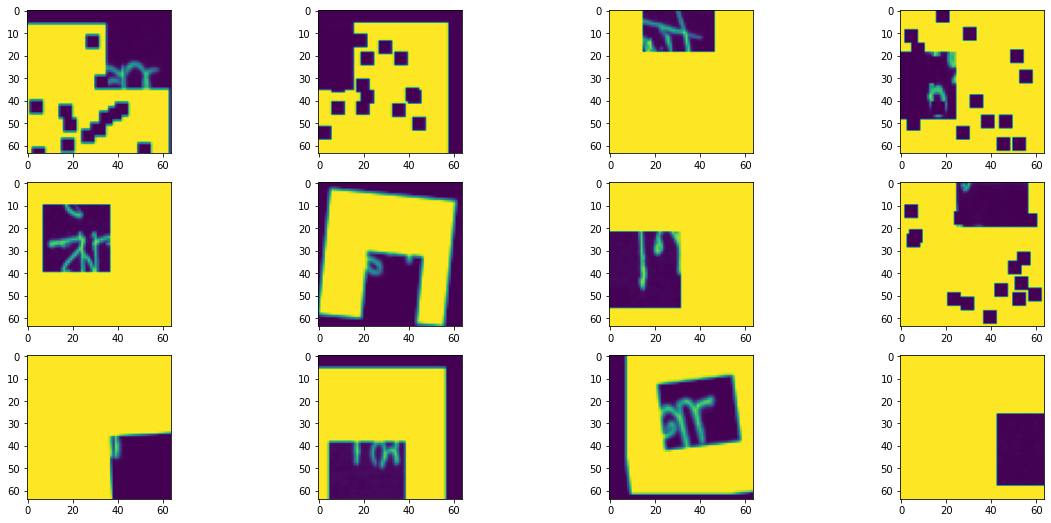

In [11]:
print('Cutmix Augmentation with first image displayed as all yellow')
gen = DataGenerator(X_train,y_train,np.arange(len(X_train)),shuffle=True,augment=True,
            batch_size=BATCH_SIZE,cutmix=True,yellow=True)

row=3; col=4;
plt.figure(figsize=(20,(row/col)*12))
for batch in gen:
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.imshow(batch[0][j,:,:,0])
    plt.show()
    break

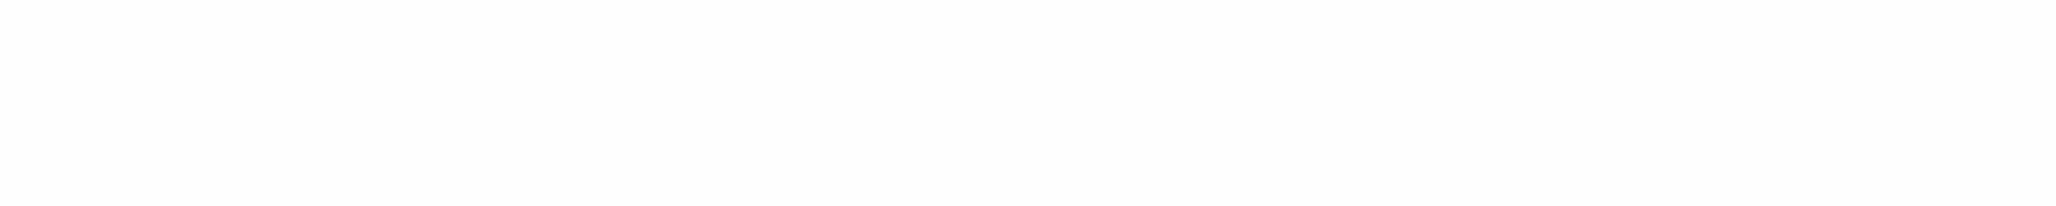

# STEP 3: Build Model
We will use transfer learning from a pretrained ImageNet CNN
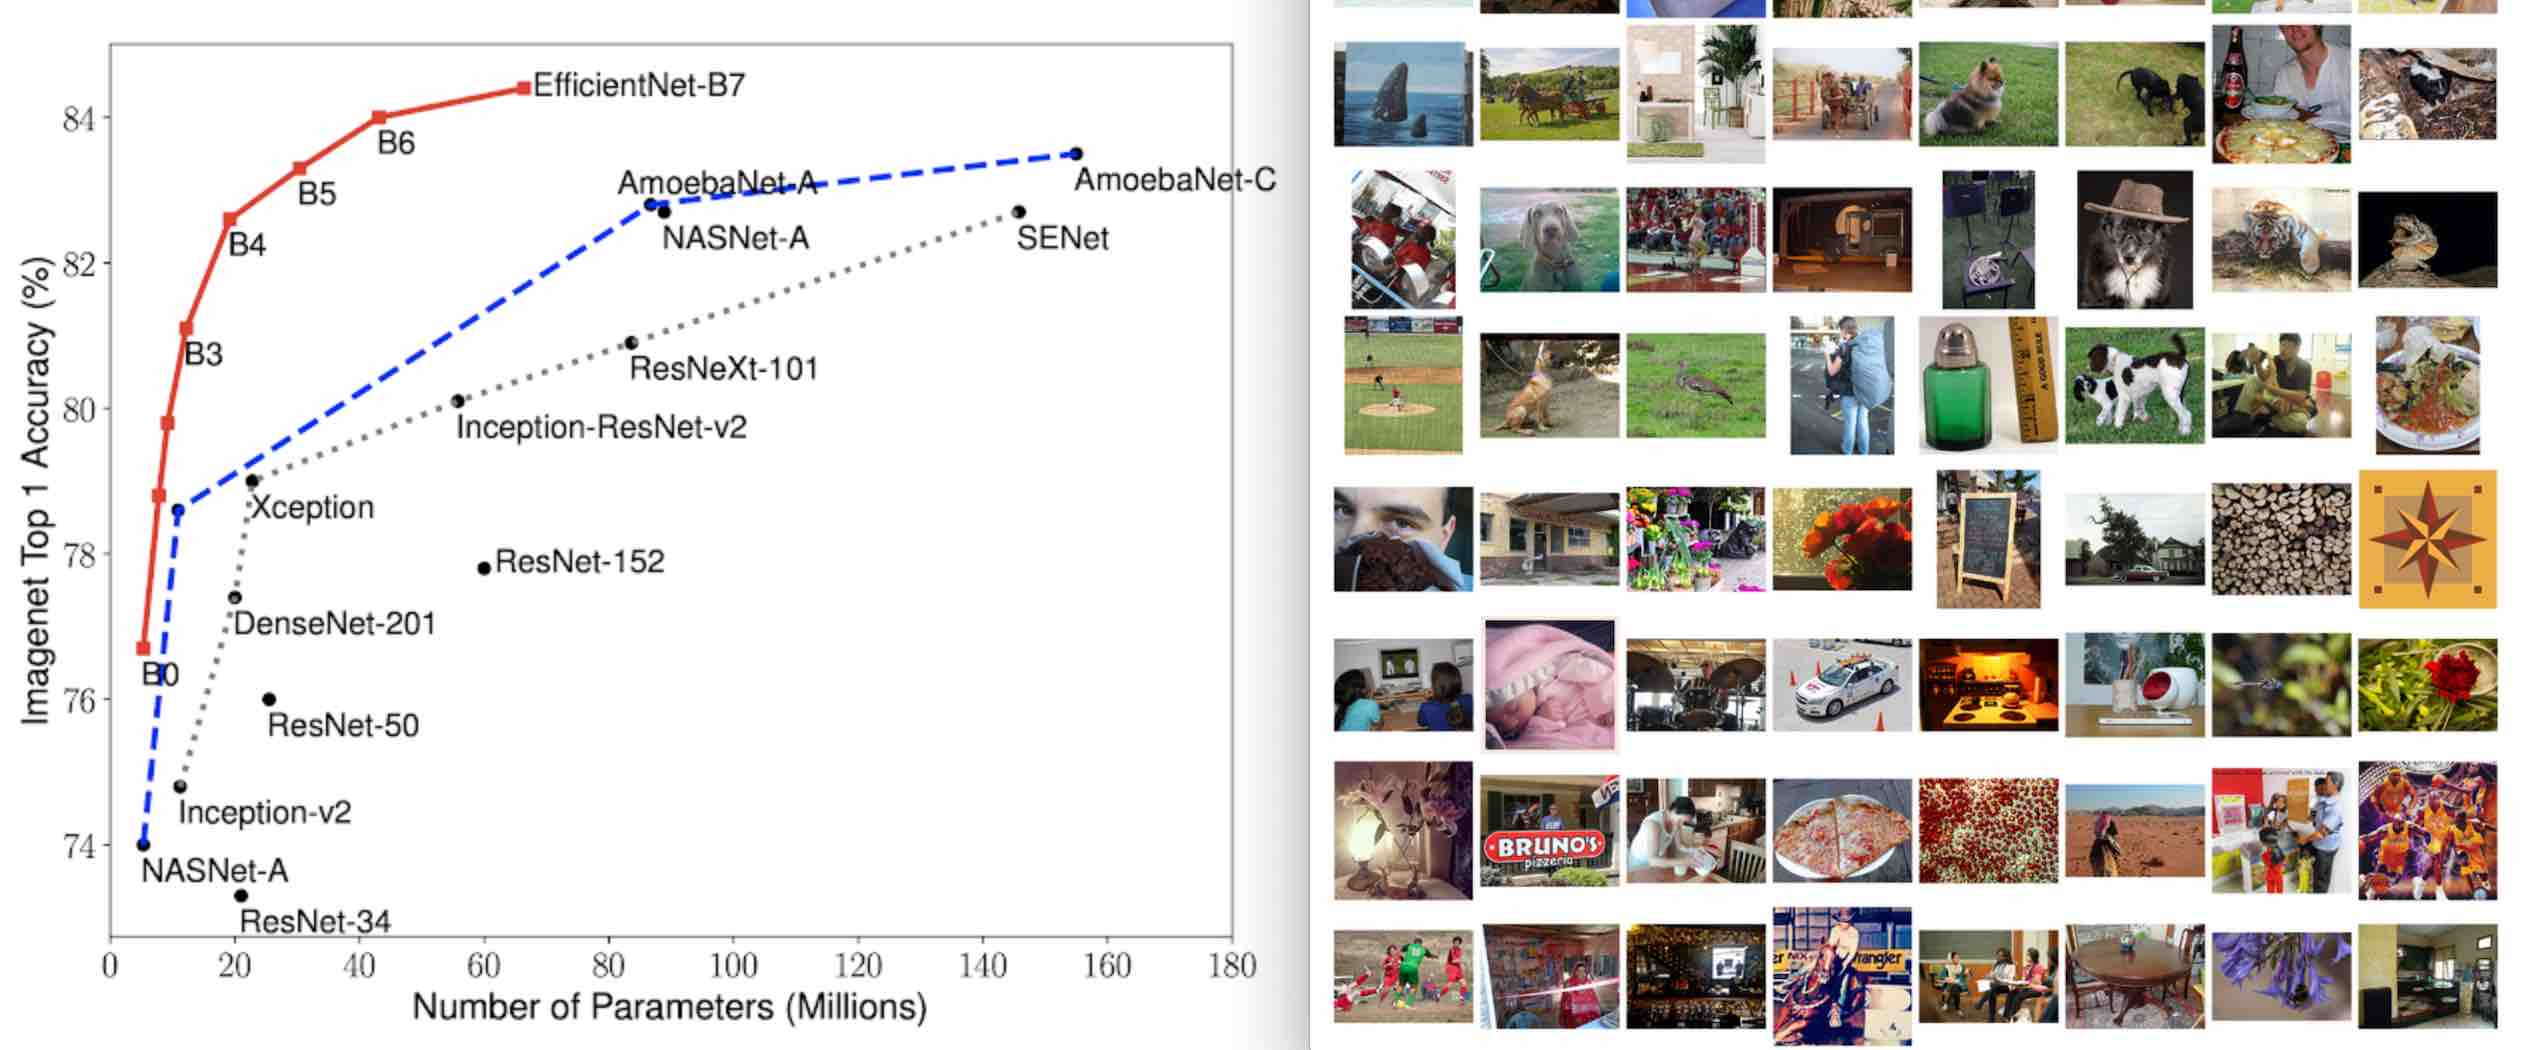

In [12]:
def build_model():
    
    inp = tf.keras.Input(shape=(DIM,DIM,1))
    inp2 = tf.keras.layers.Concatenate()([inp, inp, inp])
    #base_model = efn.EfficientNetB4(weights='imagenet',include_top=False, input_shape=(DIM,DIM,3))
    base_model = efn.EfficientNetB4(weights=None,include_top=False, input_shape=(DIM,DIM,3)) 
    base_model.load_weights('../models/efnB4.h5')

    x = base_model(inp2)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)    
    x1 = tf.keras.layers.Dense(168, activation='softmax',name='x1',dtype='float32')(x)
    x2 = tf.keras.layers.Dense(11, activation='softmax',name='x2',dtype='float32')(x)
    x3 = tf.keras.layers.Dense(7, activation='softmax',name='x3',dtype='float32')(x)
    
    model = tf.keras.Model(inputs=inp, outputs=[x1,x2,x3])
    opt = tf.keras.optimizers.Adam(lr=0.00001)
    wgt = {'x1': 1.5, 'x2': 1.0, 'x3':1.0}
    model.compile(loss='categorical_crossentropy', optimizer = opt,\
              metrics=['categorical_accuracy'], loss_weights=wgt)
        
    return model

# Validation Metric and Logging
Competition metric is macro recall

In [13]:
from sklearn.metrics import f1_score
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, valid_data, target, fold, mm=0, rr=0, patience=10):
        self.valid_inputs = valid_data
        self.valid_outputs = target
        self.fold = fold
        self.patience = patience
        self.mm = mm
        self.rr = rr
        
    def on_train_begin(self, logs={}):
        self.valid_f1 = [0]
        
    def on_epoch_end(self, epoch, logs={}):
        
        preds = self.model.predict(self.valid_inputs)
        preds0 = np.argmax(preds[0],axis=1)
        preds1 = np.argmax(preds[1],axis=1)
        preds2 = np.argmax(preds[2],axis=1)
        
        r1 = recall_score(self.valid_outputs[0],preds0,average='macro')
        r2 = recall_score(self.valid_outputs[1],preds1,average='macro')
        r3 = recall_score(self.valid_outputs[2],preds2,average='macro')
                
        a1 = accuracy_score(self.valid_outputs[0],preds0)
        a2 = accuracy_score(self.valid_outputs[1],preds1)
        a3 = accuracy_score(self.valid_outputs[2],preds2)
        
        f1 = 0.5*r1+0.25*r2+0.25*r3
                
        # LOG TO FILE
        f = open('log-%i-%i.txt'%(self.mm,self.rr),'a')
        f.write('#'*25); f.write('\n')
        f.write('#### FOLD %i EPOCH %i\n'%(self.fold+1,epoch+1))
        f.write('#### ACCURACY: a1=%.5f, a2=%.5f, a3=%.5f\n' % (a1,a2,a3) )
        f.write('#### MACRO RECALL: r1=%.5f, r2=%.5f, r3=%.5f\n' % (r1,r2,r3) )
        f.write('#### CV/LB: %.5f\n' % f1 ) 
       
        print('\n'); print('#'*25)
        print('#### FOLD %i EPOCH %i'%(self.fold+1,epoch+1))
        print('#### ACCURACY: a1=%.5f, a2=%.5f, a3=%.5f' % (a1,a2,a3) )
        print('#### MACRO RECALL: r1=%.5f, r2=%.5f, r3=%.5f' % (r1,r2,r3) )
        print('#### CV/LB: %.5f' % f1 )
        print('#'*25)

        self.valid_f1.append(f1)
        x = np.asarray(self.valid_f1)
        if np.argsort(-x)[0]==(len(x)-self.patience-1):
            print('#### CV/LB no increase for %i epochs: EARLY STOPPING' % self.patience)
            f.write('#### CV/LB no increase for %i epochs: EARLY STOPPING\n' % self.patience)
            self.model.stop_training = True
            
        if (f1>0.000)&(f1>np.max(self.valid_f1[:-1])):
            print('#### Saving new best...')
            f.write('#### Saving new best...\n')
            self.model.save_weights('fold%i-m%i-%i.h5' % (self.fold,self.mm,self.rr))
            
        f.close()

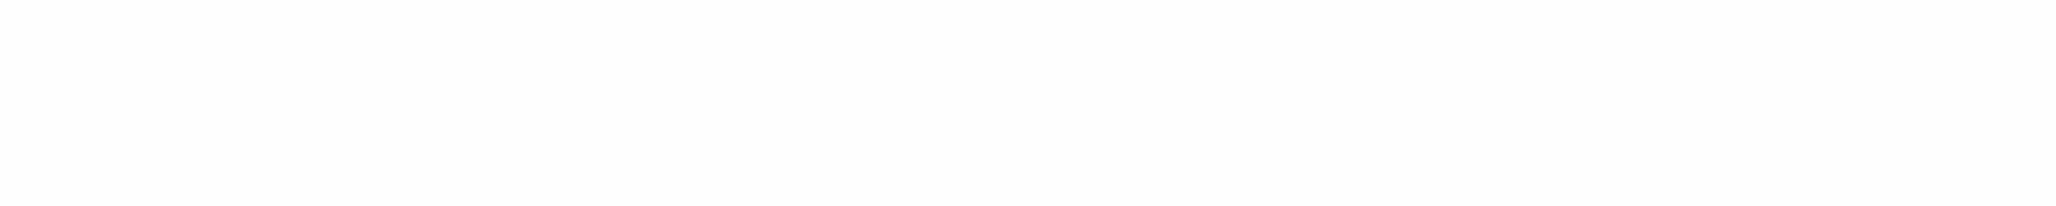

# STEP 4: Training Schedule

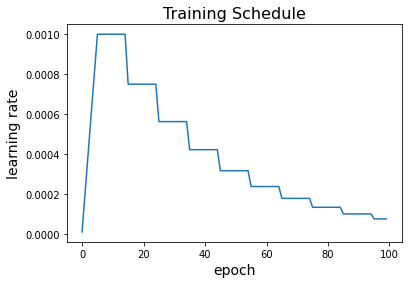

In [14]:
# CUSTOM LEARNING SCHEUDLE
LR_START = 1e-5
LR_MAX = 1e-3
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_STEP_DECAY = 0.75

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = LR_MAX * LR_STEP_DECAY**((epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)//10)
    return lr
    
lr2 = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

rng = [i for i in range(100)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y); 
plt.xlabel('epoch',size=14); plt.ylabel('learning rate',size=14)
plt.title('Training Schedule',size=16); plt.show()

# Train Model
When validation score doesn't increase for 15 epochs, we stop training to save time. In this tutorial, we only train for 20 epochs. If you increase training to 150 epochs, then this model can score CV/LB 0.98. (Also change code to load 100% train images instead of 25%). Using larger image size and larger EfficientNet can increase CV/LB to 0.99

In [15]:
# TRAIN MODEL

oof1 = np.zeros((X_train.shape[0],168))
oof2 = np.zeros((X_train.shape[0],11))
oof3 = np.zeros((X_train.shape[0],7))


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold,(idxT,idxV) in enumerate(skf.split(X_train,y_train[:,0])):
         
    print('#'*25)
    print('### FOLD %i' % (fold+1))
    print('### train on %i images. validate on %i images'%(len(idxT),len(idxV)))
    print('#'*25)
    
    K.clear_session()
    with strategy.scope():
        model = build_model()
    
    train_gen = DataGenerator(X_train,y_train,idxT,shuffle=True,augment=True,
            batch_size=BATCH_SIZE,cutmix=True)
    val_x = DataGenerator(X_train,y_train,idxV,shuffle=False,augment=False,cutmix=False,
            labels=False,batch_size=BATCH_SIZE*4)
    val_y = [y_train[idxV,0],y_train[idxV,1],y_train[idxV,2]]
        

    cc = CustomCallback(valid_data=val_x, target=val_y, fold=fold, mm=mm, rr=rr, patience=15)
    h = model.fit(train_gen, epochs = 20, verbose=1, callbacks=[cc,lr2])

    print('#### Loading best weights...')
    model.load_weights('fold%i-m%i-%i.h5' % (fold,mm,rr))
    
    val_x = DataGenerator(X_train,y_train,idxV,shuffle=False,augment=False,cutmix=False,
            labels=False,batch_size=BATCH_SIZE*4)
    oo = model.predict(val_x)
    oof1[idxV,] = oo[0]
    oof2[idxV,] = oo[1]
    oof3[idxV,] = oo[2]

    # SAVE OOF and IDXV
    np.save('oof1-%i-%i'%(mm,rr),oof1)
    np.save('oof2-%i-%i'%(mm,rr),oof2)
    np.save('oof3-%i-%i'%(mm,rr),oof3)
    np.save('idxV-%i-%i'%(mm,rr),idxV)
    np.save('y_train-%i-%i'%(mm,rr),y_train)
    break

#########################
### FOLD 1
### train on 40168 images. validate on 10042 images
#########################
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/repl

79/79 [==============================] - 21s 263ms/step - x3_categorical_accuracy: 0.7987 - x1_categorical_accuracy: 0.4358 - loss: 6.4215 - x1_loss: 2.9537 - x2_categorical_accuracy: 0.6956 - x2_loss: 1.2366 - x3_loss: 0.7544 - lr: 0.0010

Epoch 00010: LearningRateScheduler reducing learning rate to 0.001.
Epoch 10/20
79/79 [==============================] - ETA: 0s - x3_categorical_accuracy: 0.8054 - x1_categorical_accuracy: 0.4555 - loss: 6.3019 - x1_loss: 2.8966 - x2_categorical_accuracy: 0.7105 - x2_loss: 1.2142 - x3_loss: 0.7427

#########################
#### FOLD 1 EPOCH 10
#### ACCURACY: a1=0.77086, a2=0.94135, a3=0.93547
#### MACRO RECALL: r1=0.72136, r2=0.91114, r3=0.87967
#### CV/LB: 0.80838
#########################
#### Saving new best...
79/79 [==============================] - 20s 257ms/step - x3_categorical_accuracy: 0.8054 - x1_categorical_accuracy: 0.4555 - loss: 6.3019 - x1_loss: 2.8966 - x2_categorical_accuracy: 0.7105 - x2_loss: 1.2142 - x3_loss: 0.7427 - lr: 0.00

#### Loading best weights...


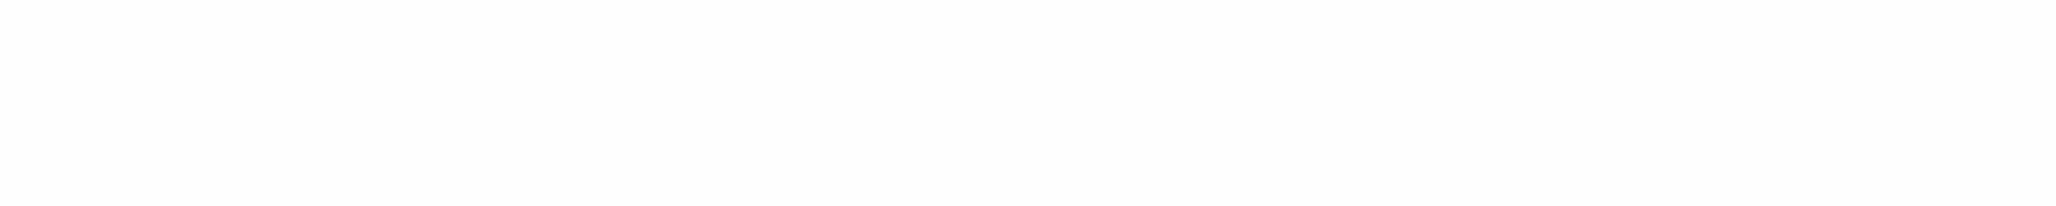

# STEP 5: Post Process
Competition metric is macro recall. Training loss did not optimize this so we will below.

In [16]:
oo = model.predict(val_x,verbose=1)
oof1[idxV,] = oo[0]
oof2[idxV,] = oo[1]
oof3[idxV,] = oo[2]

5/5 [==============================] - 0s 92ms/step


In [17]:
oof1b = np.argmax(oof1[idxV,],axis=1)
oof2b = np.argmax(oof2[idxV,],axis=1)
oof3b = np.argmax(oof3[idxV,],axis=1)

r1 = recall_score(y_train[idxV,0],oof1b,average='macro')
r2 = recall_score(y_train[idxV,1],oof2b,average='macro')
r3 = recall_score(y_train[idxV,2],oof3b,average='macro')
r = 0.5*r1+0.25*r2+0.25*r3
print('CV/LB without Post Process %.5f'%r)

CV/LB without Post Process 0.89199


In [18]:
EXP = -0.9

s = pd.Series(oof1b)
vc = s.value_counts().sort_index()
mat1 = np.diag(vc.astype('float32')**(EXP))

s = pd.Series(oof2b)
vc = s.value_counts().sort_index()
mat2 = np.diag(vc.astype('float32')**(EXP))

s = pd.Series(oof3b)
vc = s.value_counts().sort_index()
mat3 = np.diag(vc.astype('float32')**(EXP))

In [19]:
oof1b = np.argmax(oof1[idxV,].dot(mat1),axis=1)
oof2b = np.argmax(oof2[idxV,].dot(mat2),axis=1)
oof3b = np.argmax(oof3[idxV,].dot(mat3),axis=1)

r1 = recall_score(y_train[idxV,0],oof1b,average='macro')
r2 = recall_score(y_train[idxV,1],oof2b,average='macro')
r3 = recall_score(y_train[idxV,2],oof3b,average='macro')
r = 0.5*r1+0.25*r2+0.25*r3
print('CV/LB with Post Process %.5f'%r)

CV/LB with Post Process 0.91278


# Let's Review

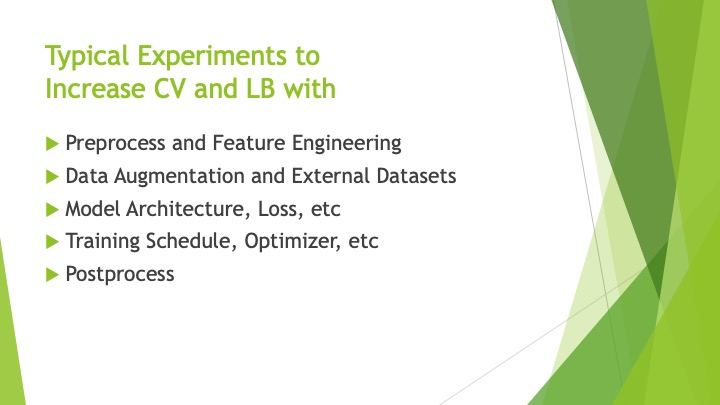
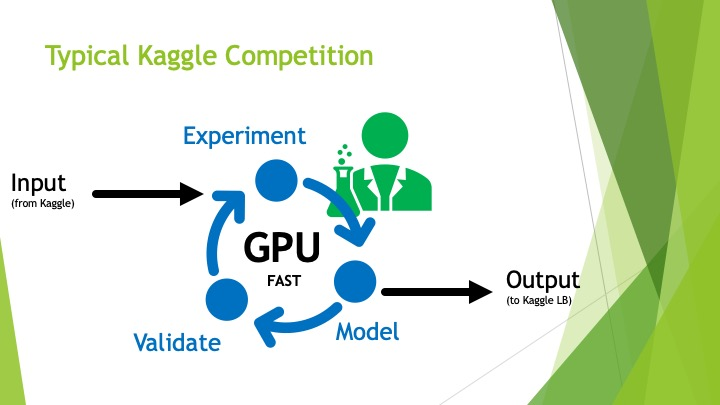

# Predict Test and Submit to Kaggle
After experimenting many times, we use our best model to predict Kaggle test set.

## Preprocess Test

In [20]:
# PREPROCESS TEST
def getTest(x):
    f = 'test_image_data_%i.parquet'%x
    img = pd.read_parquet('../data/raw/'+f) # Pandas dataframe
    img = img.iloc[:,1:].values.reshape((-1,137,236,1)) # Numpy Array
    img2 = np.zeros((img.shape[0],DIM,DIM,1),dtype='float32')
    for j in range(img.shape[0]):
        img2[j,:,:,0] = cv2.resize(img[j,],(DIM,DIM),interpolation = cv2.INTER_AREA)
    return (255 - img2)/255.

## Predict and Postprocess Test

In [21]:
EXP = -0.9
del X_train; gc.collect()

# LOAD BEST MODEL
model.load_weights('fold%i-m%i-%i.h5' % (fold,mm,rr))

# PREDICT TEST
preds1 = []; preds2 = []; preds3 = []
for x in [0,1,2,3]:
    preds = model.predict(getTest(x),verbose=1)
    preds1.append(preds[0])
    preds2.append(preds[1])
    preds3.append(preds[2])

pred1 = np.argmax(np.vstack(preds1),axis=1)
pred2 = np.argmax(np.vstack(preds2),axis=1)
pred3 = np.argmax(np.vstack(preds3),axis=1)

# APPLY POST PROCESS
s = pd.Series(pred1)
vc = s.value_counts().sort_index()
df = pd.DataFrame({'a':np.arange(168),'b':np.ones(168)})
df.b = df.a.map(vc); df.fillna(df.b.min(),inplace=True)
mat1 = np.diag(df.b.astype('float32')**(EXP))

s = pd.Series(pred2)
vc = s.value_counts().sort_index()
df = pd.DataFrame({'a':np.arange(11),'b':np.ones(11)})
df.b = df.a.map(vc); df.fillna(df.b.min(),inplace=True)
mat2 = np.diag(df.b.astype('float32')**(EXP))

s = pd.Series(pred3)
vc = s.value_counts().sort_index()
df = pd.DataFrame({'a':np.arange(7),'b':np.ones(7)})
df.b = df.a.map(vc); df.fillna(df.b.min(),inplace=True)
mat3 = np.diag(df.b.astype('float32')**(EXP))

# APPLY POST PROCESS
pred1 = np.argmax(np.vstack(preds1).dot(mat1),axis=1)
pred2 = np.argmax(np.vstack(preds2).dot(mat2),axis=1)
pred3 = np.argmax(np.vstack(preds3).dot(mat3),axis=1)

1/1 [==============================] - 0s 1ms/step


## Write Submission CSV

In [22]:
row_id = []; target = []
for i in range(len(pred1)):
    row_id += [f'Test_{i}_grapheme_root', f'Test_{i}_vowel_diacritic', f'Test_{i}_consonant_diacritic']
    target += [pred1[i], pred2[i], pred3[i]]
sub = pd.DataFrame({'row_id': row_id, 'target': target})
sub.to_csv('submission.csv', index=False)
sub.head()

,row_id,target
0,Test_0_grapheme_root,3
1,Test_0_vowel_diacritic,0
2,Test_0_consonant_diacritic,0
3,Test_1_grapheme_root,93
4,Test_1_vowel_diacritic,2


In [23]:
print('Notebook elapsed time = %.1f minutes'%((time.time()-startNB)/60))

Notebook elapsed time = 17.2 minutes
